In [1]:
import ROOT as rt
import root_numpy as rtnp
import numpy as np
from matplotlib import pyplot as plt
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from helper_functions import getRecoTime
from array import array
import CMS_lumi, tdrstyle
import math

tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1

CMS_lumi.extraText = "     Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.13/02


In [9]:
fpath = {}
tree = {}

fpath['ggh20'] = '/home/cms/Desktop/LLP/jetNtuple_RunIISummer16/withoutISR/jetNtuple_glueball/jetNtuple_glueball_ggh_M-50_CTau-1000mm_pt20.root'
# fpath['vbfh20'] = '/home/cms/Desktop/LLP/jetNtuple_RunIISummer16/withoutISR/jetNtuple_glueball/jetNtuple_glueball_vbfh_M-50_CTau-1000mm_pt20.root'
# fpath['wh20'] = '/home/cms/Desktop/LLP/jetNtuple_RunIISummer16/withoutISR/jetNtuple_glueball/jetNtuple_glueball_wh_M-50_CTau-1000mm_pt20.root'
# fpath['zh20'] = '/home/cms/Desktop/LLP/jetNtuple_RunIISummer16/withoutISR/jetNtuple_glueball/jetNtuple_glueball_zh_M-50_CTau-1000mm_pt20.root'
# # fpath['vbfh30'] = '/home/cms/Desktop/LLP/jetNtuple_RunIISummer16/withoutISR/jetNtuple_glueball/jetNtuple_glueball_vbfh_M-50_CTau-1000mm_pt30.root'
fpath['qcd'] = '/home/cms/Desktop/LLP/jetNtuple_RunIISummer16/withoutISR/jetNtuple_glueball/jetNtuple_QCD_HT300to500.root'
# fpath['fourjet'] = '/home/cms/Desktop/LLP/jetNtuple_4jet/jetNtuple_M-500_CTau-1000mm_pt20.root'

legend = {'ggh20': 'ggh, M = 50 GeV',
        'vbfh20':  'vbfh, M = 50 GeV',
          'zh20': 'zh, M = 50 GeV',
          'wh20': 'wh, M = 50 GeV',
          'qcd': 'QCD HT 300-500 GeV',
          'fourjet': 'Four jet M = 500 GeV'
         }

for k,v in fpath.iteritems():
    print k, v
    tree[k] = rtnp.root2array(v)
    #tree[k] = rtnp.tree2array(v)
    #jet_max_pt_array = [np.max(x) for x in tree[k]["jetPt"]]
    a = tree[k]["jetPt"]
    print a[:-1][0]

ggh20 /home/cms/Desktop/LLP/jetNtuple_RunIISummer16/withoutISR/jetNtuple_glueball/jetNtuple_glueball_ggh_M-50_CTau-1000mm_pt20.root
[]
qcd /home/cms/Desktop/LLP/jetNtuple_RunIISummer16/withoutISR/jetNtuple_glueball/jetNtuple_QCD_HT300to500.root
[104.180176  69.4402    37.214607  33.06379   32.81417 ]


# Reco Time Signal vs. bkg

In [11]:
algo = 1 # which time algorithm to use, 0 is energy weighted, 1 is energy squared weighted, 2 is median
pt_cut = 0
rechit = 1
reco_time = {}
reco_time_check = {}
gen_time = {}
time_diff = {}
gen_pt = {}
for k, T in tree.items():
    reco_time[k] = []
    reco_time_check[k] = []
    gen_time[k] = []
    time_diff[k] = []
    gen_pt[k] = []
    if not k == 'qcd':
        gLLP_daughter_match_jet_index = T['gLLP_daughter_match_jet_index']
        gLLP_daughter_travel_time = T['gLLP_daughter_travel_time']
        matched_jets = np.logical_and(np.logical_not( gLLP_daughter_travel_time == -666), np.logical_not( gLLP_daughter_match_jet_index == 666))
        gLLP_daughter_match_jet_index = gLLP_daughter_match_jet_index[matched_jets]
        rechit_T_1 =  T['jet_rechit_T_Ecut1']
        jet_rechits_T = T['jet_rechits_T']
        jet_rechits_E = T['jet_rechits_E'] #(events,jets,rechits)
        gen_time_origin = T['gen_time']
        gLLP_daughter_pt = T['gLLP_daughter_pt']
        for i in range(len(T['gLLP_daughter_match_jet_index'])): #loop through each event
            for j in range(2): #loop through first 2 b-jets
                index = T['gLLP_daughter_match_jet_index'][i][j]
                if gLLP_daughter_pt[i][j] < pt_cut: 
                    continue
                if not index == 666 and matched_jets[i][j]: #matched and barrel jets
                    reco_temp = getRecoTime(algo, rechit,jet_rechits_T[i][index],jet_rechits_E[i][index])
                    if not reco_temp == None:
                        reco_time_check[k].append(rechit_T_1[i][index])
                        reco_time[k].append(reco_temp)
                        gen_time[k].append(gen_time_origin[i][j])
                        time_diff[k].append(reco_temp-gen_time_origin[i][j])
                        gen_pt[k].append(gLLP_daughter_pt[i][j])
       

    else:  #for QCD
        match_jet_index = T['genParticleQCD_match_jet_index']
        nGenQCDParticles = [x for x in T['nGenQCDParticles']]
        rechit_T_1 =  T['jet_rechit_T_Ecut1']
        jet_rechits_T = T['jet_rechits_T']
        jet_rechits_E = T['jet_rechits_E'] #(events,jets,rechits)
        for i in range(len(match_jet_index)): #loop through each event
            for j in range(nGenQCDParticles[i]):
                index = match_jet_index[i][j]
                if not index == 666: #if matched
                    reco_temp = getRecoTime(algo, rechit,jet_rechits_T[i][index],jet_rechits_E[i][index])
                    if not reco_temp == None:
                        reco_time[k].append(reco_temp)
                        reco_time_check[k].append(rechit_T_1[i][index])
#                         gen_pt[k].append(gLLP_daughter_pt[i][j])

    gen_pt[k] = np.array(gen_pt[k])
    reco_time_check[k] = np.array(reco_time_check[k])
    reco_time[k] = np.array(reco_time[k])
    gen_time[k] = np.array(gen_time[k])
    time_diff[k] = np.array(time_diff[k])

('ggh20', 597.0)
('qcd', 15316.0)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ../plots/reco_time_sig_bkg_median.pdf has been created


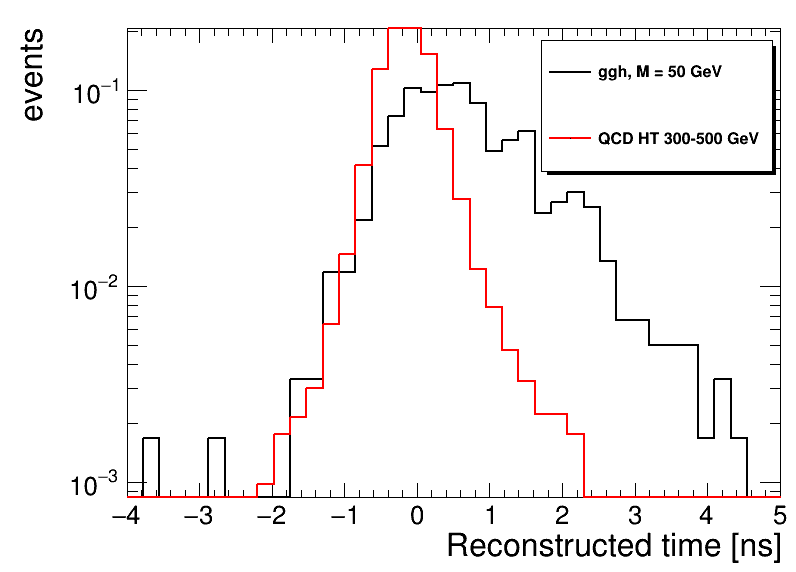

In [12]:
# Plotting Reco Time
c = rt.TCanvas('c','c', 800, 600)
h = {}
leg = rt.TLegend(0.68,0.70,0.97,0.93);
leg.SetTextSize(0.03)

i = 0
for k, reco in reco_time.items():
    h[k] = create_TH1D( np.array(reco), axis_title=['Reconstructed time [ns]', 'events'], name=k, binning=[40,-4,5])
    h[k].SetLineColor(std_color_list[i])
    print(k,h[k].Integral())
    leg.AddEntry(h[k],legend[k])
    if i == 0:
        h[k].DrawNormalized()
    h[k].DrawNormalized('same')
    i += 1
leg.Draw()
c.SetLogy()
c.Draw()

c.SaveAs("../plots/reco_time_sig_bkg_median.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ../plots/gen_time_sig_bkg_median.pdf has been created


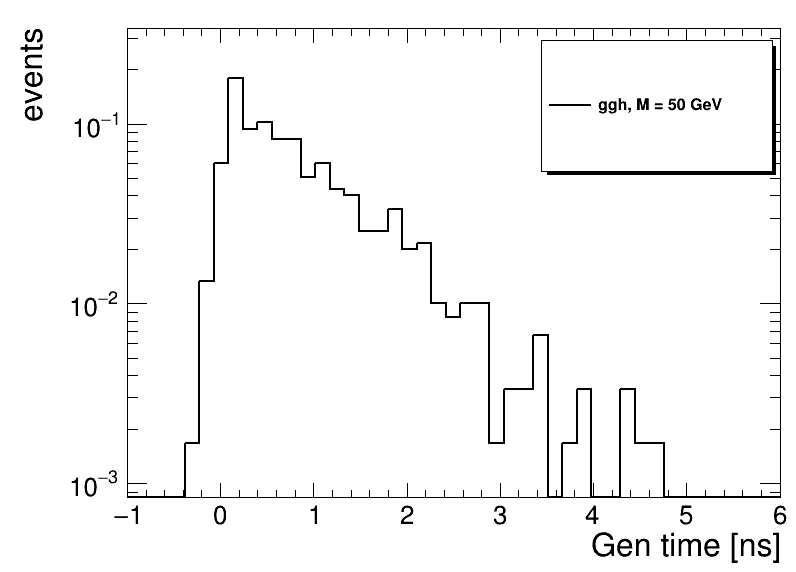

In [13]:
# Plotting Gen Time
c = rt.TCanvas('c','c', 800, 600)
h = {}
leg = rt.TLegend(0.68,0.70,0.97,0.93);
leg.SetTextSize(0.03)

i = 0
for k, gen in gen_time.items():
    if not k == 'qcd':
        h[k] = create_TH1D( np.array(gen), axis_title=['Gen time [ns]', 'events'], name=k, binning=[45,-1,6])
        h[k].SetLineColor(std_color_list[i])
        leg.AddEntry(h[k],legend[k])
        if i == 0:
            h[k].DrawNormalized()
        h[k].DrawNormalized('same')
        i += 1
leg.Draw()
c.SetLogy()
c.Draw()
c.SaveAs("../plots/gen_time_sig_bkg_median.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ../plots/time_diff_sig_bkg_median.pdf has been created


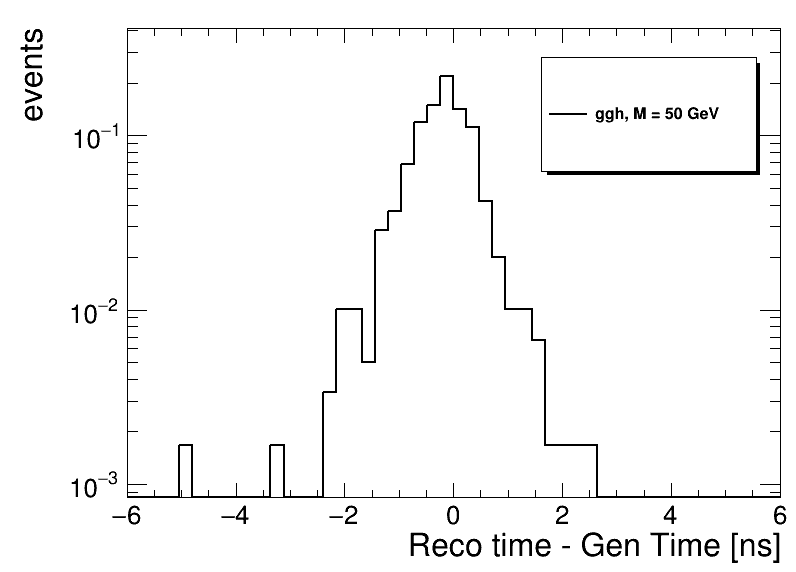

In [14]:
# Plotting Reco - Gen Time
c = rt.TCanvas('c','c', 800, 600)
h = {}
leg = rt.TLegend(0.68,0.70,0.95,0.9);
leg.SetTextSize(0.03)

i = 0
for k, time in time_diff.items():
    if not k == 'qcd':
        h[k] = create_TH1D( np.array(time), axis_title=['Reco time - Gen Time [ns]', 'events'], name=k, binning=[50,-6,6])
        h[k].SetLineColor(std_color_list[i])
        leg.AddEntry(h[k],legend[k])
#         h[k].GetYaxis().SetRangeUser(0,10000)
        if i == 0:
            h[k].DrawNormalized()
        h[k].DrawNormalized('same')
        i += 1
leg.Draw()
c.SetLogy()
c.Draw()
c.SaveAs("../plots/time_diff_sig_bkg_median.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file ../plots/gen_time_vs_time_diffggh20.pdf has been created


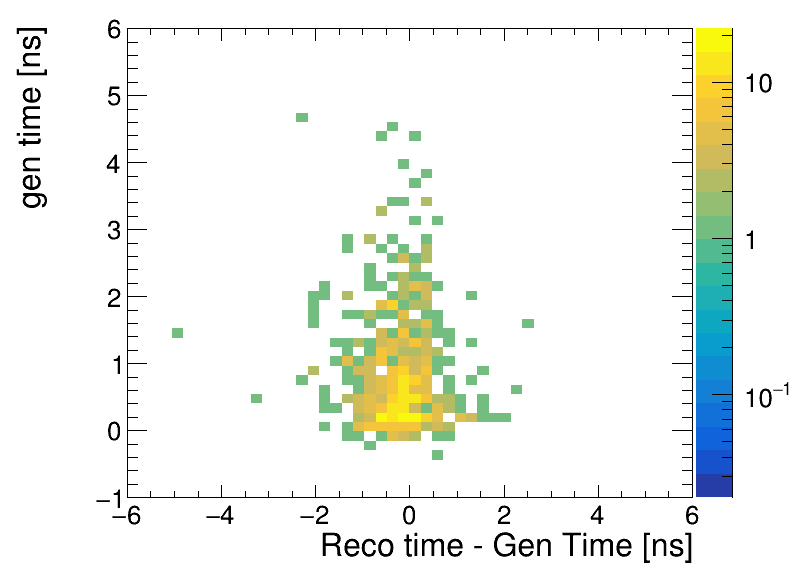

In [18]:
# Plotting some 2d maps between reco time, gen time and pt

c = rt.TCanvas('c','c', 800, 600)
h_pt = {}
h_time = {}
h_recot_pt = {}
leg = rt.TLegend(0.70,0.70,0.95,0.9);
leg.SetTextSize(0.03)

color = [1,2,4,6,8]
i = 0
for k, time in time_diff.items():
    if not k == 'qcd':
        h_time[k] = create_TH2D( np.column_stack((time,gen_time[k])), axis_title=['Reco time - Gen Time [ns]', 'gen time [ns]','events'], binning=[50,-6,6,50,-1,6])
        h_pt[k] = create_TH2D( np.column_stack((time,gen_pt[k])), axis_title=['Reco time - Gen Time [ns]', 'gen pt [GeV]','events'], binning=[50,-6,6,100,0,2000])
        h_recot_pt[k] = create_TH2D( np.column_stack((reco_time[k],gen_pt[k])), axis_title=['Reco time', 'gen pt [GeV]','events'], binning=[50,-6,6,50,-1,250])
key = 'ggh20'
leg.AddEntry(h_pt[key],legend[key])
h_time[key].Draw('colz')
c.SetLogz()
c.SetRightMargin(0.13)
# leg.Draw()
c.Draw()
c.SaveAs("../plots/gen_time_vs_time_diff_"+key+".pdf")

# Helper Function

In [ ]:
def getRecoTime(algorithm,rechit_cut, eventN, jetN):
    # 0 is energy weighted, 1 is energy squared weighted, 2 is median
    reco_time = T['jet_rechits_T']
    reco_energy = T['jet_rechits_E'] #(events,jets,rechits)
    rechit_time = reco_time [eventN][jetN]
    rechit_energy = reco_energy[eventN][jetN]
    rechit_energy = rechit_energy[np.logical_not(rechit_time == -666)]
    rechit_time = rechit_time[np.logical_not(rechit_time == -666)]
    rechit_time = rechit_time[rechit_energy > rechit_cut]
    rechit_energy = rechit_energy[rechit_energy > rechit_cut]
    assert(len(rechit_time) == len(rechit_energy))
#     if np.std(rechit_time) > 0.5:
#         return None
    # from ucsb analysis: RMS jet time/median jet time < 0.4
    if np.sum(rechit_energy) > 0.0 and len(rechit_time) > 0:
        if algorithm == 0:
            return np.sum(np.multiply(rechit_time,rechit_energy)/np.sum(rechit_energy))
        elif algorithm == 1:
            return np.sum(np.multiply(rechit_time,rechit_energy*rechit_energy)/np.sum(rechit_energy*rechit_energy))
        elif algorithm == 2:
            return np.median(rechit_time)
    else:
        return None

In [ ]:
def binningY(histo2D,min_event):#returns an appropriate binning in y direction
    bins = []
    i=0
    nbinsy =  histo2D.GetNbinsY()
    while i < nbinsy:
        counter = 0
        while counter < min_event:
            h1 = histo2D.ProjectionX("h"+str(i),i+1,i+1)
            counter += h1.Integral()
            i+=1
            if i >nbinsy:
                break
        bins.append(i)

    bins = bins[:len(bins)-2]+[bins[len(bins)-1]]
    return bins

In [ ]:
def histo2D_projectionFit(histo2D, bins, gaus_thr):
    proj = []
    bw = histo2D.GetYaxis().GetBinWidth(1)
    left_edge = histo2D.GetYaxis().GetBinLowEdge(1)

    x_bins = [(x-1)*bw+left_edge for x in bins]
    res = rt.TH1F('trd','res', len(bins)-1,array( 'f', x_bins))
    res_eff = rt.TH1F('trd','res_eff', len(bins)-1,array( 'f', x_bins))
    scale = rt.TH1F('scale','scale',len(bins)-1,array( 'f', x_bins))
    for i in range(len(bins)-1):
        key = 'bin'+str(i)
        proj.append(histo2D.ProjectionX("h"+str(i),bins[i],bins[i+1]-1))
        y_low = histo2D.GetYaxis().GetBinLowEdge(bins[i])
        y_up = histo2D.GetYaxis().GetBinLowEdge(bins[i+1]-1)+histo2D.GetYaxis().GetBinWidth(1)

    for i in range(len(proj)):
        h1 = proj[i]
        hnew = h1.Clone("hnew")
        hnew = hnew.Rebin(2)
        SS = rt.TSpectrum()
        n_pks = SS.Search(hnew, 0.1, "", 0.5)
        x_pos = SS.GetPositionX()
        y_pos = SS.GetPositionY()
        pks = []
        if n_pks == 0:
            hnew.SetLineColor(4)
    #         hnew.Rebin(2)
            hnew.GetXaxis().SetRangeUser(-5,5)
            hnew.DrawCopy()
            print("npks",i,hnew.Integral(),n_pks)
            break
        n_pk = hnew.FindBin(x_pos[0])
        thr = gaus_thr* hnew.GetBinContent(n_pk)
        n_low = n_pk
        while hnew.GetBinContent(n_low) > thr:
            n_low -= 1
        x_low = hnew.GetBinCenter(n_low)    
        n_up = n_pk
        while hnew.GetBinContent(n_up) > thr:
            n_up += 1
        x_up = hnew.GetBinCenter(n_up)
        r = hnew.Fit('gaus', 'LRSQ+', '', x_low, x_up)
        r = r.Get()
        scale.SetBinContent(i+1,r.Parameter(1))
        scale.SetBinError(i+1,r.ParError(1))
        if abs(r.Parameter(1)-hnew.GetMean())>1:
            print("scale fit warning", i,r.Parameter(1),hnew.GetMean())

        n_pk = h1.FindBin(r.Parameter(1))
        thr = 0.68 * h1.Integral()
        counter = h1.GetBinContent(n_pk)*1.0
        n_low = n_pk
        n_up = n_pk
        flag = True
        while counter < thr:
            if flag:
                n_low -= 1
                counter += h1.GetBinContent(n_low)
            else:
                n_up += 1
                counter += h1.GetBinContent(n_up)
            flag = not flag
        sigma_eff = (n_up - n_low) *h1.GetBinWidth(1)
    #         sigma_eff = h1.GetStdDev()
        res.SetBinContent(i+1,sigma_eff)
        res.SetBinError(i+1,h1.GetBinWidth(1))
        res_eff.SetBinContent(i+1,r.Parameter(2))
        res_eff.SetBinError(i+1,r.ParError(2))
    return scale, res, res_eff